<h1>Predictive Alerts for Proactive System Failures</h1>

In [1]:
##Load the required Module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:

df = pd.read_csv('SystemHealthReport.csv')
df.shape

# Convert TIMESTAMP column to datetime format
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])

# Drop the TIMESTAMP column (since it's not useful for Random Forest)
df = df.drop(columns=["TIMESTAMP"])
df["MEM"] += np.random.normal(0, 2, size=len(df))  # Adding slight variation
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
df.shape

(1702, 11)

In [4]:
df.head()

,CPU,MEM,LOAD,TCP_PORT_STATUS,TCP_TIME_WAITS,TPS,TOTAL_TCP,NETWORK_LATENCY,RESPONSE_TIME,THREAD_COUNT,RESTART
0,29.089796,31.421809,5.348494,29645,18473,867,48118,139.232110,241.520000,144,Healthy
1,14.791385,17.501995,2.888202,22971,16489,1267,39460,28.818149,88.981563,246,Healthy
2,82.211771,83.475540,7.808546,55270,38551,2034,93821,244.112267,342.086193,392,Yellow
3,36.879727,35.192646,4.807718,13303,4385,848,17688,10.054621,242.307801,298,Healthy
4,41.395511,46.647367,3.512964,37484,27412,621,64896,92.753090,168.949204,78,Healthy


In [5]:
restart_counts = df["RESTART"].value_counts()
df['RESTART'].unique()

array(['Healthy', 'Yellow', 'Restart'], dtype=object)

<h2>Distribution by restart types<h2>

In [6]:
print(restart_counts.index)

Index(['Healthy', 'Yellow', 'Restart'], dtype='object', name='RESTART')


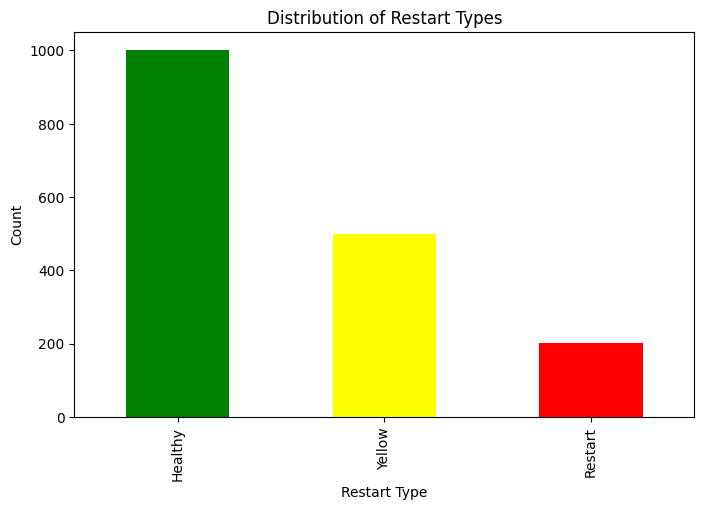

In [7]:
import matplotlib.pyplot as plt

# Define colors for different Restart categories
color_map = {"Healthy": "green", "Yellow": "yellow", "Restart": "red"}

# Create bar chart
plt.figure(figsize=(8, 5))
restart_counts.plot(kind="bar", color=[color_map[key] for key in restart_counts.index])

# Set labels and title
plt.xlabel("Restart Type")
plt.ylabel("Count")
plt.title("Distribution of Restart Types")

# Show the plot
plt.show()


<h2>Prepare the Data</h2>

In [8]:
#One Hot encoding for restrat column 

df_encoded = pd.get_dummies(df, columns=["RESTART"], dtype=int)

X = df_encoded.drop(columns=["RESTART_Healthy", "RESTART_Yellow", "RESTART_Restart"])  # All features except restart columns
Y = df_encoded[["RESTART_Healthy", "RESTART_Yellow", "RESTART_Restart"]]  # Restart columns as target
X,Y

(            CPU        MEM      LOAD  TCP_PORT_STATUS  TCP_TIME_WAITS   TPS  \
 0     29.089796  31.421809  5.348494            29645           18473   867   
 1     14.791385  17.501995  2.888202            22971           16489  1267   
 2     82.211771  83.475540  7.808546            55270           38551  2034   
 3     36.879727  35.192646  4.807718            13303            4385   848   
 4     41.395511  46.647367  3.512964            37484           27412   621   
 ...         ...        ...       ...              ...             ...   ...   
 1697  87.040100  81.553698  6.146590            53351           32851  1926   
 1698  84.743715  73.459266  6.429860            57553           37740  1963   
 1699  69.051604  20.233663  4.321339            15919           14807   587   
 1700  75.359253  73.751728  6.466238            56473           32818  2091   
 1701  78.185254  79.672277  7.359871            57140           34972  1853   
 
       TOTAL_TCP  NETWORK_LATENCY  RES

<h2>Train and Test Split the Data</h2>

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42, shuffle=True)
Y_train['RESTART_Healthy'].value_counts()

RESTART_Healthy
1    800
0    561
Name: count, dtype: int64

<h2>Generate the Random Forest</h2>

In [10]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)

In [11]:
!pip uninstall -y numpy scikit-learn
!pip install numpy scikit-learn --upgrade

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Successfully uninstalled numpy-1.25.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata (31 kB)
  Using cached numpy-1.25.2-cp39-cp39-macosx_10_9_x86_64.whl.metadata (5.6 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-macosx_10_9_x86_64.whl (12.1 MB)
Using cached numpy-1.25.2-cp39-cp39-macosx_10_9_x86_64.whl (20.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 1.0.3 requires numpy==1.23.5, but you have numpy 1.25.2 which is incompatible.
d2l 1.0.3 requires scipy==1.10.1, but you have scipy 1.9.3 which is incompatible.


<h2>Lets try one Prediction</h2>

In [12]:
predictions = rf_model.predict(X_test)

In [13]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00        41

   micro avg       1.00      1.00      1.00       341
   macro avg       1.00      1.00      1.00       341
weighted avg       1.00      1.00      1.00       341
 samples avg       1.00      1.00      1.00       341



In [14]:
print("Features expected by the model:", rf_model.feature_names_in_)
print("Your X_test features:", X_test.columns.tolist())

Features expected by the model: ['CPU' 'MEM' 'LOAD' 'TCP_PORT_STATUS' 'TCP_TIME_WAITS' 'TPS' 'TOTAL_TCP'
 'NETWORK_LATENCY' 'RESPONSE_TIME' 'THREAD_COUNT']
Your X_test features: ['CPU', 'MEM', 'LOAD', 'TCP_PORT_STATUS', 'TCP_TIME_WAITS', 'TPS', 'TOTAL_TCP', 'NETWORK_LATENCY', 'RESPONSE_TIME', 'THREAD_COUNT']


In [15]:
# Check shapes first:
print(Y_test.shape, predictions.shape)

(341, 3) (341, 3)


In [16]:
# Fix shapes (if necessary)
Y_test = np.array(Y_test).ravel()
predictions = np.array(predictions).ravel()

In [17]:
# Verify again:
print(Y_test.shape, predictions.shape)

(1023,) (1023,)


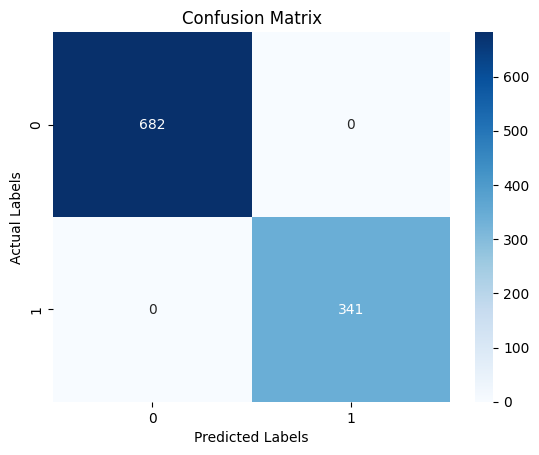

In [18]:
# Now run confusion_matrix again:
conf_matrix = confusion_matrix(Y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Assume rf_model is your trained RandomForest model
importances = rf_model.feature_importances_
features = X_train.columns

In [24]:
features, importances 

(Index(['CPU', 'MEM', 'LOAD', 'TCP_PORT_STATUS', 'TCP_TIME_WAITS', 'TPS',
        'TOTAL_TCP', 'NETWORK_LATENCY', 'RESPONSE_TIME', 'THREAD_COUNT'],
       dtype='object'),
 array([0.21848867, 0.00051901, 0.10984716, 0.04639604, 0.09506979,
        0.04589466, 0.14922688, 0.09412395, 0.12614405, 0.11428978]))

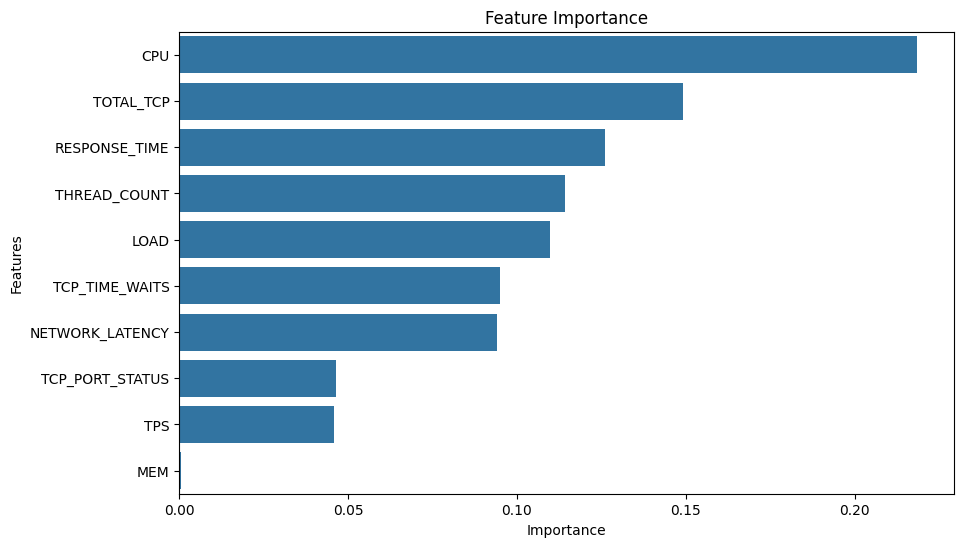

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
